# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

In [ ]:
!pip install transformers==4.28.0 -q datasets rouge sacrebleu
!git config --global credential.helper store
!huggingface-cli login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 5.1 MB/s eta 0:00:00

    _|    _|  _|    _|    _|_|_| 

In [ ]:
# importing dependencies
import transformers
from datasets import load_dataset, Dataset
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from transformers import AutoProcessor, AutoModelForCausalLM, TrainingArguments, Trainer, EncoderDecoderModel
#from evaluate import load
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
import base64
import nltk
nltk.download('wordnet')
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
from sacrebleu.metrics import BLEU, CHRF
import os
import io
os.environ["WANDB_DISABLED"] = "true"

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Import requests
import requests
from pathlib import Path 

# Measure time
from timeit import default_timer as timer

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldnt' be lower than 0.11
print(f'PyTorch version: {torch.__version__}\ntorchvision version: { torchvision.__version__}')

PyTorch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


In [ ]:
dataset = load_dataset("agestau/preproc-fashion-products")
ds=dataset["train"]
dataset7 = ds.remove_columns(['subCategory'])
dataset7

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/36145 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/agestau___parquet/agestau--preproc-fashion-products-fe572d0abe1a2515/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'text'],
    num_rows: 36145
})

In [ ]:
dataset7[0]["text"]

'Men Navy Blue Shirt'

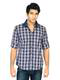

In [ ]:
dataset7[0]["image"]

In [ ]:
# Sampling for testing
#dataset7_sample = dataset7.shuffle().select(range(100))
#dataset7_sample

Dataset({
    features: ['image', 'text'],
    num_rows: 100
})

In [ ]:
dataset7 = dataset7.train_test_split(test_size=0.1)
train_ds = dataset7["train"]
test_ds = dataset7["test"]

#dataset7_sample = dataset7_sample.train_test_split(test_size=0.1)
#train_ds = dataset7_sample["train"]
#test_ds = dataset7_sample["test"]

In [ ]:
# Creating a function to time our experiments

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [ ]:
train_dataset = ImageCaptioningDataset(train_ds, processor)
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

test_dataset = ImageCaptioningDataset(test_ds, processor)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)

In [ ]:
sample_batch = next(iter(train_dataloader))
print(sample_batch)

{'pixel_values': tensor([[[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          ...,
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],

         [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          ...,
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749]],

         [[2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459

In [ ]:
# Function for training and testing loops

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    train_loss = 0
    model.train()

    #for batch, data in enumerate(data_loader):
        # Send data to GPU
        #input_ids = data['input_ids'].to(device)
        #pixel_values = data['pixel_values'].to(device)

    for idx, batch in enumerate(data_loader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        # 1. Forward pass
        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)
        loss = outputs.loss
        train_loss += loss.item()

        # 2. Optimizer zero grad
        optimizer.zero_grad()

        # 3. Loss backward
        loss.backward()

        # 4. Optimizer step
        optimizer.step()

        # Print loss per batch
        if (idx + 1) % 10 == 0:
          print(f"Batch {idx+1}/{len(data_loader)} - Loss: {loss:.5f}")

    # Calculate loss per epoch and print out
    train_loss /= len(data_loader)
    print(f"Train loss: {train_loss:.5f}")
    

In [ ]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              device: torch.device = device):
    test_loss = 0
    model.eval()  # Put model in evaluation mode

    with torch.inference_mode():
        #for batch, data in enumerate(data_loader):
            # Send data to GPU
            #input_ids = data['input_ids'].to(device)
            #pixel_values = data['pixel_values'].to(device)

        for idx, batch in enumerate(data_loader):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            # 1. Forward pass
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)
            loss = outputs.loss
            test_loss += loss.item()

        # Calculate loss per epoch and print out
        test_loss /= len(data_loader)
        print(f"Test loss: {test_loss:.5f}\n")

In [ ]:
#torch.manual_seed(42)

def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader):
  
    import logging
    import warnings
    logging.getLogger("transformers").setLevel(logging.ERROR)
    warnings.filterwarnings("ignore")

    bleu = BLEU()
    chrf = CHRF()

    model = model.to(device)
    model.eval()
    predictions = []
    references = []

    with torch.inference_mode():
        for idx, batch in enumerate(data_loader, start=1):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            outputs = model.generate(input_ids=input_ids,pixel_values=pixel_values,max_length=50)
            
            predicted_sentences_batch = processor.batch_decode(outputs, skip_special_tokens=True)
            predictions.extend(predicted_sentences_batch)
            
            reference_sentences_batch = [processor.decode(ids, skip_special_tokens=True) for ids in input_ids]
            references.extend(reference_sentences_batch)

            # Prints individual batch results for each natch
            if idx % 100 == 0:
                print(f"Batch {idx}:")
                print("predicted_sentences:")
                print(predicted_sentences_batch)
                print("reference_sentences:")
                print(reference_sentences_batch)
                print(type(reference_sentences_batch))
                print()

                # Compute BLEU score for the current batch
                bleu_score = bleu.corpus_score(predicted_sentences_batch, [reference_sentences_batch])
                print(f"BLEU score for Batch {idx}: {bleu_score.score}")

                # Compute CHRF score for the current batch
                chrf_score = chrf.corpus_score(predicted_sentences_batch, [reference_sentences_batch])
                print(f"CHRF score for Batch {idx}: {chrf_score.score}")

                print()  # Print an empty line for readability
        
    return {"model_name": "Fine Tuned 'BlipForConditionalGeneration' for Fashion Items",
            "bleu_score": bleu.corpus_score(predictions, [references]).score,
            "chrf_score": chrf.corpus_score(predictions, [references]).score}

In [ ]:
eval_model(model=model,data_loader=test_dataloader) 

In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start = timer()

model.to(device)

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    #sample_data = next(iter(test_dataloader))
    #print(sample_data) 
    print(f"Epoch: {epoch}\n---------")
    train_step(model=model, 
          data_loader=train_dataloader,
          optimizer=optimizer,
          device=device
    )
    test_step(model=model,
         data_loader=test_dataloader,
         device=device
    )

train_time_end = timer()
total_train_time_cnn_model = print_train_time(start=train_time_start, 
                                              end=train_time_end,
                                              device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Batch 10/6506 - Loss: 10.19910
Batch 20/6506 - Loss: 8.69794
Batch 30/6506 - Loss: 7.18618
Batch 40/6506 - Loss: 5.77508
Batch 50/6506 - Loss: 4.37921
Batch 60/6506 - Loss: 3.10857
Batch 70/6506 - Loss: 2.10818
Batch 80/6506 - Loss: 1.63804
Batch 90/6506 - Loss: 1.49530
Batch 100/6506 - Loss: 1.42361
Batch 110/6506 - Loss: 1.40648
Batch 120/6506 - Loss: 1.42840
Batch 130/6506 - Loss: 1.38223
Batch 140/6506 - Loss: 1.40426
Batch 150/6506 - Loss: 1.38489
Batch 160/6506 - Loss: 1.39146
Batch 170/6506 - Loss: 1.39795
Batch 180/6506 - Loss: 1.39339
Batch 190/6506 - Loss: 1.39414
Batch 200/6506 - Loss: 1.36577
Batch 210/6506 - Loss: 1.37510
Batch 220/6506 - Loss: 1.37482
Batch 230/6506 - Loss: 1.37072
Batch 240/6506 - Loss: 1.36976
Batch 250/6506 - Loss: 1.38444
Batch 260/6506 - Loss: 1.38287
Batch 270/6506 - Loss: 1.38380
Batch 280/6506 - Loss: 1.38210
Batch 290/6506 - Loss: 1.38236
Batch 300/6506 - Loss: 1.36892
Batch 310/6506 - Loss: 1.38948
Batch 320/6506 - Loss: 1.377

In [ ]:
model.push_to_hub("f_cap_allrecs") # all recs - 32530 training; 3615 validation; batch_size=5; 3 Epochs

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/agestau/f_cap_allrecs/commit/381cc5193e527833ca89447a86a1f2aa817d87da', commit_message='Upload BlipForConditionalGeneration', commit_description='', oid='381cc5193e527833ca89447a86a1f2aa817d87da', pr_url=None, pr_revision=None, pr_num=None)

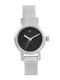

In [ ]:
# load image
example = dataset7["train"][1854]
image = example["image"]
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

men black dial watch


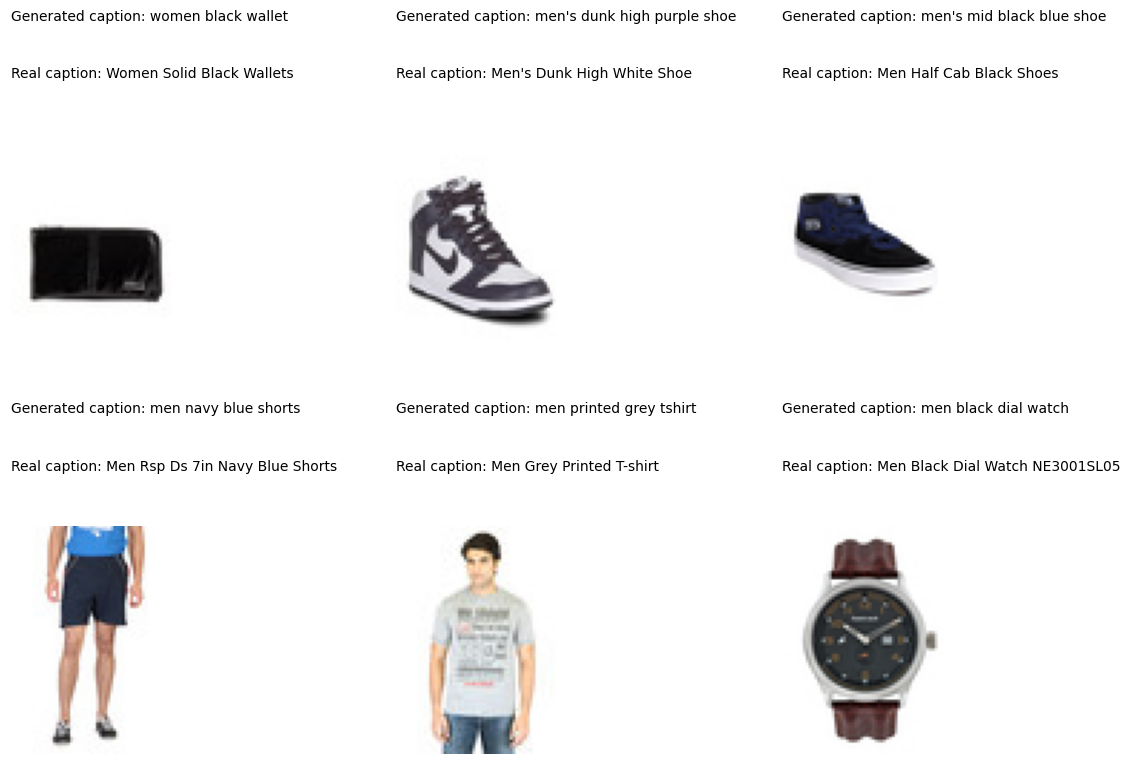

In [ ]:
from matplotlib import pyplot as plt
import random

fig = plt.figure(figsize=(12, 8))

# Convert dataset7 to a list and select 6 random examples
random_examples = random.sample(list(dataset7["train"]), 6)

# Prepare and plot the selected examples
for i, example in enumerate(random_examples):
    image = example["image"]
    real_caption = example["text"]

    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(image)
    ax.axis("off")
    ax.text(0, -20, f"Real caption: {real_caption}", fontsize=10, ha="left")
    ax.text(0, -40, f"Generated caption: {generated_caption}", fontsize=10, ha="left")

plt.tight_layout()
plt.show()


In [ ]:
#model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model_ft_100recs = BlipForConditionalGeneration.from_pretrained("agestau/f_cap_100recs")
model_ft_1000recs = BlipForConditionalGeneration.from_pretrained("agestau/f_cap_1000recs")
model_ft_allrecs = BlipForConditionalGeneration.from_pretrained("agestau/f_cap_allrecs")

In [ ]:
eval_model(model=model,data_loader=test_dataloader) 

Batch 100:
predicted_sentences:
['men swift white sports shoese', 'men yellow striped polo t - shirt', 'women breeches blue capris', 'women black breath sports shoe', 'women maroon leggingss']
reference_sentences:
['men swift white sports shoes', 'men yellow striped polo t - shirt', 'women breeches blue capri', 'women black breath sports shoe', 'women maroon leggings']
<class 'list'>

BLEU score for Batch 100: 81.91692732318536
CHRF score for Batch 100: 99.43087442012192

Batch 200:
predicted_sentences:
['women silver earringss', 'men beige trouserss', 'women silver sandalss', 'women white dial watch', 'women casual tan flatss']
reference_sentences:
['women silver earrings', 'men beige trousers', 'women silver sandals', 'women white dial watch', 'women casual tan flats']
<class 'list'>

BLEU score for Batch 200: 57.49089871602278
CHRF score for Batch 200: 98.97971072984375



KeyboardInterrupt: ignored

In [ ]:
eval_model(model=model_ft_100recs,data_loader=test_dataloader) 

KeyboardInterrupt: ignored

In [ ]:
eval_model(model=model_ft_1000recs,data_loader=test_dataloader) 

Batch 100:
predicted_sentences:
['women casual sunglasses', 'men brown leather belt', 'men black sweatshirt', 'women yellow flats', 'men grey melange t - shirt']
reference_sentences:
['women casual sunglasses', 'men brown leather belt', 'men black sweatshirt', 'women yellow flats', 'men grey melange t - shirt']
<class 'list'>

BLEU score for Batch 100: 100.00000000000004
CHRF score for Batch 100: 100.0

Batch 200:
predicted_sentences:
['women blue jeans', 'men navy & green striped polo t - shirt', 'men blue slim fit checked shirt', 'women purple t - shirt', 'quechua arpenaz flex man beige']
reference_sentences:
['women blue jeans', 'men navy & green striped polo t - shirt', 'men blue slim fit checked shirt', 'women purple t - shirt', 'quechua arpenaz flex man beige']
<class 'list'>

BLEU score for Batch 200: 100.00000000000004
CHRF score for Batch 200: 100.0

Batch 300:
predicted_sentences:
['genesis purple casual shirt', 'women green pinto checksy mobile pouch', 'women blue zip white 

{'model_name': "Fine Tuned 'BlipForConditionalGeneration' for Fashion Items",
 'bleu_score': 100.00000000000004,
 'chrf_score': 100.0}

In [ ]:
eval_model(model=model_ft_allrecs,data_loader=test_dataloader) 

Batch 100:
predicted_sentences:
['men ast 90ss graphic black t - shirts', 'women bonkers baby pink wallet', 'men leather brown formal shoes', 'women casual white heels', 'men short black shirts']
reference_sentences:
['men ast 90ss graphic black t - shirts', 'women bonkers baby pink wallet', 'men leather brown formal shoes', 'women casual white heels', 'men short black shirts']
<class 'list'>

BLEU score for Batch 100: 100.00000000000004
CHRF score for Batch 100: 100.0



ValueError: ignored

In [ ]:
model
model_ft_100recs
model_ft_1000recs
model_ft_allrecs

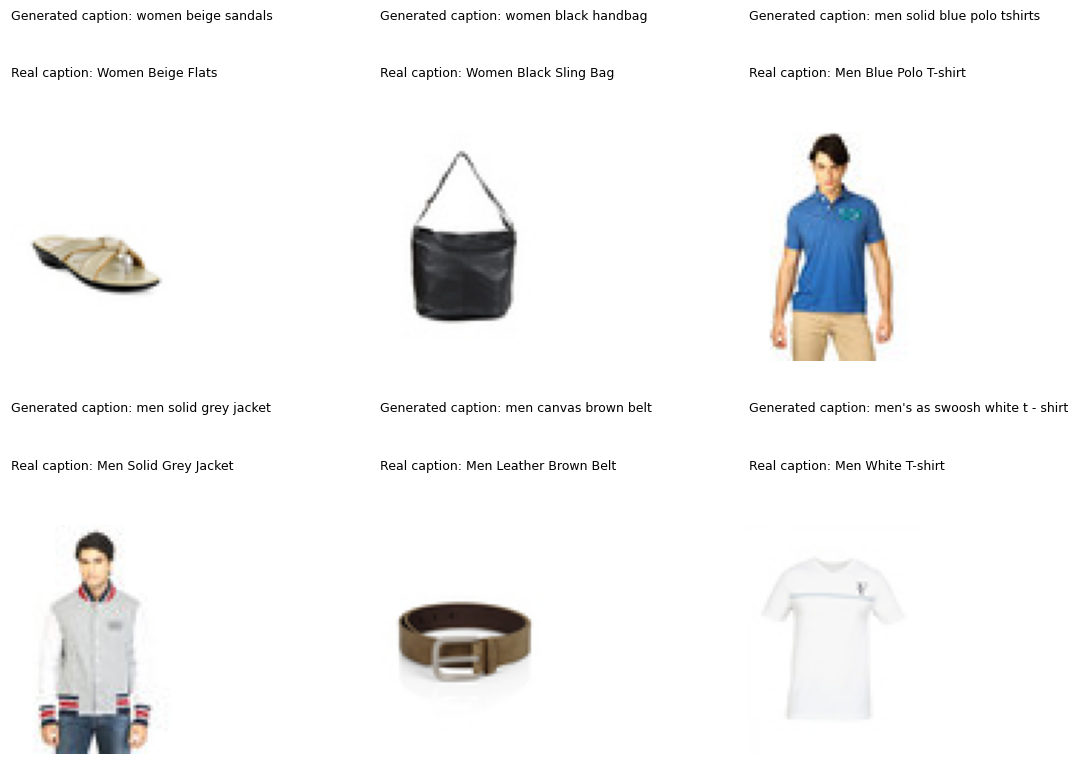

In [ ]:
from matplotlib import pyplot as plt
import random

model_plot = model_ft_allrecs.to(device)

fig = plt.figure(figsize=(12, 8))

# Convert dataset7 to a list and select 6 random examples
random_examples = random.sample(list(dataset7["train"]), 6)

# Prepare and plot the selected examples
for i, example in enumerate(random_examples):
    image = example["image"]
    real_caption = example["text"]

    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model_plot.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(image)
    ax.axis("off")
    ax.text(0, -20, f"Real caption: {real_caption}", fontsize=9, ha="left")
    ax.text(0, -40, f"Generated caption: {generated_caption}", fontsize=9, ha="left")

plt.tight_layout()
plt.show()


In [ ]:
import random
random_examples = random.sample(list(test_ds), 100)

In [ ]:


model = model.to(device)

predictions = []
references = []

# Prepare and plot the selected examples
for i, example in enumerate(random_examples):
    image = example["image"]
    real_caption = example["text"]
    references.append(real_caption.lower())

    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    #lowercased_list = [item.lower() for item in my_list]
    predictions.append(" ".join(generated_caption.split()))
    
print("reference_sentences:")
print(references)
print("predicted_sentences:")
print(predictions)
print()

print("bleu_score: ", BLEU().corpus_score(predictions, [references]).score)
print("chrf_score: ", CHRF().corpus_score(predictions, [references]).score)


reference_sentences:
['women beige handbag', 'men air maestro flight black sports shoes', 'women black flip flops', 'men egoli fg fluorescent green sports shoes', 'women purple & black skirt', 'women decade low sleek red casual shoes', 'womens blue maxi fit jeans', 'men printed navy blue t-shirt', 'men blue casual sandals', 'men white self structure shirts']
predicted_sentences:
['women beige handbag', 'men air max full court black sports shoes', 'women black flip flops', "men's mercurial victory hg hg yellow shoe", 'women pink shorts', "men's court sequence red shoe", 'women blue jeans', 'men printed navy blue sweatshirt', 'men casual blue sandals', 'men white shirt']

bleu_score:  24.15177667038276
chrf_score:  48.78861349623212


In [ ]:
def evaluate_model(model, random_examples, device):
    model = model.to(device)
    predictions = []
    references = []

    # Prepare and plot the selected examples
    for i, example in enumerate(random_examples):
        image = example["image"]
        real_caption = example["text"]
        references.append(real_caption.lower())

        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values

        generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        predictions.append(" ".join(generated_caption.split()))

    print("reference_sentences:")
    print(references)
    print("predicted_sentences:")
    print(predictions)
    print()

    print("bleu_score: ", BLEU().corpus_score(predictions, [references]).score)
    print("chrf_score: ", CHRF().corpus_score(predictions, [references]).score)

evaluate_model(model, random_examples, device)

reference_sentences:
['men brown formal shoes', 'men casual leather/felt charcoal sandal', 'men printed navy blue sweatshirts', 'women black adi weld shoes', 'men printed grey sweatshirt', 'men seattle embro white sweatshirt', 'men white socks', 'men black watch', 'men mead black belt', 'men casual blue sunglasses', 'women cream shoes', 'men black dial watch', 'women printed olive t-shirt', "men's slate taupe fabric shoe", 'men scul black white shirt', 'boys check green shirts', 'men stripes green sweater', 'men graphic print red tshirt', "men's 3s pes comb white polo t-shirt", 'women blue pendant', 'women brown comfortsoft waistband cotton stretch full leggings', 'men mairin brown casual shoes', 'women orange handbag', 'women riddim purple tshirt', "tantra kid's unisex the matrix green kidswear", 'men lifestyle black casual shoes', 'men cricket white polo t-shirt', 'women bronze sandals', 'men red checked halbert slim fit shirt', 'men blue track pants', 'men solid black jacket', 'men 

In [ ]:
evaluate_model(model_ft_allrecs, random_examples, device)

reference_sentences:
['men brown formal shoes', 'men casual leather/felt charcoal sandal', 'men printed navy blue sweatshirts', 'women black adi weld shoes', 'men printed grey sweatshirt', 'men seattle embro white sweatshirt', 'men white socks', 'men black watch', 'men mead black belt', 'men casual blue sunglasses', 'women cream shoes', 'men black dial watch', 'women printed olive t-shirt', "men's slate taupe fabric shoe", 'men scul black white shirt', 'boys check green shirts', 'men stripes green sweater', 'men graphic print red tshirt', "men's 3s pes comb white polo t-shirt", 'women blue pendant', 'women brown comfortsoft waistband cotton stretch full leggings', 'men mairin brown casual shoes', 'women orange handbag', 'women riddim purple tshirt', "tantra kid's unisex the matrix green kidswear", 'men lifestyle black casual shoes', 'men cricket white polo t-shirt', 'women bronze sandals', 'men red checked halbert slim fit shirt', 'men blue track pants', 'men solid black jacket', 'men 